# Using a transformer based model

We now have a larger dataset to work with. We previously said we wouldn't immediately jump to changing the model architecture we're using to improve our results but now we have some work on exploring our previous models errors and increasing the size of our training data we might want to see if working with a different type of model architecture improves our performance. 

## Transformers 

Transformer based models have made a massive impact on the Natural Language Processing world. {cite:p}`vaswani2017attention`

We won't dig into the deep details of how these architectures work here. If you want to learn more about how these models work there are lots of useful resources available including a free huggingface [course](https://huggingface.co/course). If you have a humanities background or interest you may also find the [Bert for Humanists](https://melaniewalsh.github.io/BERT-for-Humanists) project useful. 

One of the reasons we held of jumping straight to transformers is because of a more general concern with making sure we don't see machine learning as a process of optimising a model architecture but rather a process of trying to think about, and potentially improve our data in combination with choosing a model and improving the training process. 

The other slightly more practical reason we waited is that Transformer models are (in general) quite computationally expensive. If we are able to get sufficiently good performance using less computationally intensive methods then we might prefer to use those. With this said this can be overstated - again here we are not going to be training a model 'from scratch' (more on this shortly) but instead we will be fine-tuning an existing model. We can often do this with a single GPU and still get very good results. 

## The 🤗 ecosystem  

Hugging Face is a company which has made a massive impact on the NLP landscape over the past couple of years. It is focused on helping ["Build, train and deploy state of the art models powered by the reference open source in natural language"](https://huggingface.co/). One of the tools developed by Hugging Face is the [transformers](https://huggingface.co/transformers/) library. This library provides implementations of many transformer based models. This already provides us an easier way to access state of the art models without needing to implement and maintain them ourselves, however, one of the real benefits for us it the ability to use transformers in combination with models from the huggingface ['model hub'](huggingface.co/models). 

## The 🤗 model hub

We saw in previous notebooks how fine-tuning can be useful to reduce the amount of training data and compute resources  we need to build a useful model. This, arguably, becomes even more important for transformer based models which can be expensive to train. The Hugging Face ['model hub'](huggingface.co/models) gives us access to a huge number of pre-trained models ranging trained for a large number of tasks on a growing number of languages. 


```{image} figs/hub.png
:alt: screenshot of hugginface hub
:class: bg-primary mb-1
:align: center
```

This means we can potentially find a model that already does something we want, or close to what we want. If we aren't lucky enough to find the exact model we need we can often find a model which will still work well on our task. 

We'll shortly see how we can also contribute to this model hub. 

## blurr

There are different ways we could use the [transformers](https://huggingface.co/transformers/) library. Since we already used fastai library in earlier parts of this notebook it might be nice to stick to this an API which is close to the fastai library. Fortunately for us [blurr](https://github.com/ohmeow/blurr) gives us exactly this blurr is a

> [library that integrates huggingface transformers with version 2 of the fastai framework](https://github.com/ohmeow/blurr)

## Install requirements 

In [1]:
!pip install git+https://github.com/ohmeow/blurr.git

  Cloning https://github.com/ohmeow/blurr.git to /tmp/pip-req-build-r8_9rr9w
  Running command git clone -q https://github.com/ohmeow/blurr.git /tmp/pip-req-build-r8_9rr9w


## Imports

In [2]:
import pandas as pd
import torch
from transformers import *
from fastai.text.all import *
from blurr.data.all import *
from blurr.modeling.all import *

## Loading our snorkel training data

We'll load the data we created previously using our labelling functions/snorkel. 

In [3]:
df = pd.read_csv("snorkel_train.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2718: DtypeWarning: Columns (17) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Preparing our data 

Some of this will look fairly familiar from the previous but there is a little bit more 'housekeeping' to do now. We'll briefly explain what is happening in this different stages. 

First we create a variable which just stores the number of labels we could have. This is a bit redundant here since we know it's two but we might not always remember how many labels we have. 

In [4]:
n_labels = len(df["snorkel_genre"].unique())
n_labels

2

We now need to specify the type of model we want to use. We want to do text classification, which is also known as 'sequence classification'. We use the Transformers libraries [`Auto Classes`](https://huggingface.co/transformers/model_doc/auto.html) to do a lot of the setup work of creating a model for the task we want to do (text classifcation) using a particular model architecture. This makes it very easy to swap the model we use without having to change our code. 

In [5]:
model_cls = AutoModelForSequenceClassification

We now pass in the name of the model we want to use as our initial pre-trained model. We could choose from many of the models in the huggingface hub to serve as the starting point for our new transformer based model. In this case we choose 'distilbert-base-cased', this is a lighter version of Bert which is slightly less computationally expensive to train, we also use a 'cased' model. This means that "Dog" is different to "dog", since we have relatively short sequences of text and capitalisation is often important in a book title our intuition was that this model might work a little better than an uncased model. 

In [6]:
pretrained_model_name = "distilbert-base-cased"

In [7]:
config = AutoConfig.from_pretrained(pretrained_model_name)
config.num_labels = n_labels

We now use a blur method `get_hf_objects` to get all of the various components of our model (tokenizer, etc.)

In [8]:
hf_arch, hf_config, hf_tokenizer, hf_model = BLURR.get_hf_objects(
    pretrained_model_name, model_cls=model_cls, config=config
)

We now load our data

In [9]:
blocks = (HF_TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), CategoryBlock)
dblock = DataBlock(
    blocks=blocks,
    get_x=ColReader("Title"),
    get_y=ColReader("snorkel_genre"),
    splitter=ColSplitter(),
)
dls = dblock.dataloaders(df, bs=16)

We can take a look at our data as we saw before

In [10]:
dls.show_batch(dataloaders=dls, max_n=2)

,text,target
0,"Los Héroes y las Maravillas del Mundo.... Anales del mundo desde los tiempos bíblicos hasta nuestros dias.... Gran Memorandum histórico... que comprende íntegras las obras siguientes. La Imparcial... Historia Universal, escrita por el sabio Benedictino Clemente y su tan celebrado Arte de comprobar los datos de las fechas históricas, crónicas y otros antiguos documentos ;... continuada hasta hoy dia por M. de Saint Allais ; la Historia de Alejandro el Grande, escrita por Quinto Curcio, la de Cártago y Roma, Anibal y los Escipiones, Pompeyo y Cesar, continuados los famosos Comentarios de este último ; la de la guerra de Yugurta y Catilina, trasladado íntegro todo el Salustio. La Historia de la guerra de los Judios contra los Romanos.... Descripcion del Capitolio, destruccion de Jerusalen, Martirio de los Macabeos, etc. escrita por Flavio Josefo, traducida del original Griego... acompañadas dichas historias con las fideles tablas cronológicas de la citada obra de Clemente.... Seguido todo de los tan celebrados cuadros de la pintura del hombre y de las maravillas que le rodean por... Buffon, Cuvier, Lacepede,... precedido del discurso sobre la Historia Universal por... Bossuet.... Dispuesto, ordenado, y completado el cuerpo general de la obra hasta el dia que termine por D. de Mora y Casarusa. Revisada la parte religiosa que comprende por I. Sayol y E",Non-fiction
1,"Les Corte - Real et leurs voyages au Nouveau - Monde, d'après des documents nouveaux... tirés des archives de Lisbonne et de Modène. Suivi du texte inédit d'un récit de la troisième expédition de Gaspar Corte - Real et d'une importante carte nautique portugaise de l'année 1502 reproduite ici pour la première fois. Mémoire lu à l'Académie des inscriptions et belles - lettres, etc",Non-fiction


## Creating our learner 

We now create a fastai learner. This is a bit more verbose than previously because we specify an optimizer and don't use the `text_classifier_learner` convenience function but directly use a fastai `Learner` class. 

In [11]:
model = HF_BaseModelWrapper(hf_model)

In [12]:
learn = Learner(
    dls,
    model,
    opt_func=partial(Adam, decouple_wd=True),
    loss_func=CrossEntropyLossFlat(),
    metrics=[F1Score(average="macro")],
    cbs=[HF_BaseModelCallback],
    splitter=hf_splitter,
).to_fp16()
learn.unfreeze()

As we saw before we can use the learning rate finder to help find a suitable learning rate 

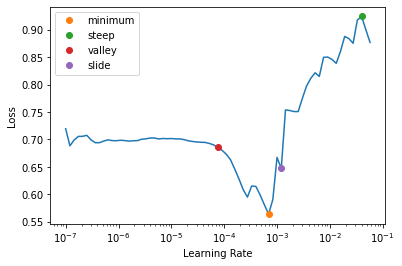

In [13]:
suggested = learn.lr_find(suggest_funcs=(minimum, steep, valley, slide))

## Training our model

We are now ready to train our model. We again set a high number of epochs but as we did before we set a callback to stop training if we don't see any improvement. We are fairly 'aggressive' here with how long we accept for the model to not improve since transformers can take some time to converge and we might stop too early if we set our 'patience' value too low. 

epoch,train_loss,valid_loss,f1_score,time
0,0.060123,0.051887,0.983149,01:12
1,0.039713,0.042197,0.985315,01:12
2,0.027020,0.041089,0.986084,01:12
3,0.029702,0.038905,0.988239,01:12
4,0.018178,0.049402,0.986665,01:12
5,0.009065,0.049319,0.988239,01:12
6,0.020446,0.060483,0.979554,01:12
7,0.002944,0.063162,0.987050,01:13
8,0.011935,0.062683,0.984502,01:13
9,0.004221,0.060780,0.986274,01:12


Better model found at epoch 0 with f1_score value: 0.9831487323424476.


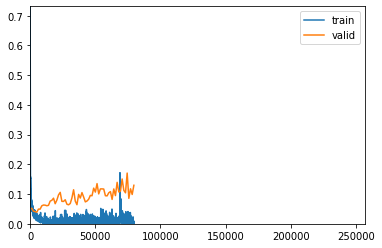

Better model found at epoch 1 with f1_score value: 0.9853153996035091.
Better model found at epoch 2 with f1_score value: 0.9860838987594831.
Better model found at epoch 3 with f1_score value: 0.9882387687911827.
Better model found at epoch 22 with f1_score value: 0.9898127825545218.
No improvement since epoch 22: early stopping


In [14]:
learn.fit_one_cycle(
    200,
    lr_max=suggested.valley,
    cbs=[
        ShowGraphCallback(),
        SaveModelCallback(monitor="f1_score"),
        EarlyStoppingCallback(monitor="f1_score", patience=40),
    ],
)

In [15]:
learn.save("stage-1")

Path('models/stage-1.pth')

### Testing our model
As before we want to see how our model does on unseen test data. 

In [16]:
df_test = pd.read_csv("test_errors.csv")

In [17]:
df_test = df_test[["title", "true_label"]]
df_test = df_test.dropna(subset=["true_label"]).copy()
df_test = df_test[df_test.true_label.isin({"non_fiction", "fiction"})]
test_data = learn.dls.test_dl(df_test.loc[:, "title"])
preds = learn.get_preds(dl=test_data)
probs = preds[0]
predictions = probs.argmax(1)
true_labels = df_test.true_label.astype("category").cat.codes

In [18]:
from sklearn.metrics import f1_score, classification_report, accuracy_score

In [19]:
print(
    classification_report(
        true_labels,
        predictions,
    )
)

              precision    recall  f1-score   support

           0       0.91      0.94      0.93       296
           1       0.97      0.95      0.96       554

    accuracy                           0.95       850
   macro avg       0.94      0.95      0.94       850
weighted avg       0.95      0.95      0.95       850



We can see that we do get some improvements compared to our previous model 🤗!

## Sharing our model (stage 1)

We now have a model that is doing fairly well. Although we constructed this model for our particular task and data, it's still possible that others will benefit from this model so we might want to consider uploading it to the 🤗 model hub. Let's start by poking around inside the `model` object. 

In [20]:
model.hf_model.config

DistilBertConfig {
  "_name_or_path": "distilbert-base-cased",
  "activation": "gelu",
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "hidden_dim": 3072,
  "initializer_range": 0.02,
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "output_past": true,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.12.5",
  "vocab_size": 28996
}

We can see that this includes a bunch of information about our model. One thing which we haven't got here is our labels. At the moment when we make predictions we get `0` or `1` back. To fix this we can quickly assign a dictionary to the `model.config` `id2label` attribute. 

In [ ]:
dict(enumerate(dls.vocab))

{0: 'Fiction', 1: 'Non-fiction'}

In [ ]:
model.hf_model.config.id2label = dict(enumerate(dls.vocab))

We can now upload to the hub. There are various ways in which we can do this, here we'll use the command line interface. First we login:

In [ ]:
!transformers-cli login

For Colab we also need to install [git lfs](https://git-lfs.github.com/). If you haven't come accross this before [git lfs](https://git-lfs.github.com/) is a tool for working with large files using Git. It can be very useful for versioning files, in this case our model, which are too big for GitHub to accept otherwise. In particular it can be very helpful in keeping track of versions of models. 

In [ ]:
!sudo apt install git-lfs

Reading package lists... Done
Building dependency tree       
Reading state information... Done
The following NEW packages will be installed:
  git-lfs
0 upgraded, 1 newly installed, 0 to remove and 40 not upgraded.
Need to get 2,129 kB of archives.
After this operation, 7,662 kB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu bionic/universe amd64 git-lfs amd64 2.3.4-1 [2,129 kB]
Fetched 2,129 kB in 1s (1,682 kB/s)
debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 76, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
Selecting previously unselected package git-lfs.
(Reading database ... 148492 files and directories c

We initialize a git repo and install git lfs

In [ ]:
!git init
!git lfs install

Initialized empty Git repository in /content/.git/
Updated git hooks.
Git LFS initialized.


We also put in some basic data for Git

In [ ]:
!git config --global user.email EMAIL
!git config --global user.name NAME

## Push to the 🤗 hub

In [ ]:
model.hf_model.push_to_hub("bl-books-genre", private=True)

Cloning https://huggingface.co/davanstrien/bl-books-genre into local empty directory.


Upload file pytorch_model.bin:   0%|          | 3.45k/251M [00:00<?, ?B/s]

To https://huggingface.co/davanstrien/bl-books-genre
   784ae4b..b063856  main -> main



'https://huggingface.co/davanstrien/bl-books-genre/commit/b0638563b8155fa1699beda323a0a3cfbccf4731'

In [ ]:
hf_tokenizer.push_to_hub("bl-books-genre", private=True)

For now we keep our model 'private', in a subsequent section we'll look at a few things which we probably want to do before we unleash our model into the wild. 

``````{note}
In this notebook we finally got to play with a transformer model, and we do benefit from slightly improved performance. However, much of this performance came from having built a better training set, and having already built a model and begun to understand the errors of this model. We originally trained a transformer model (an even bigger one) on this data and got worse results than in our fastai model. It is almost always worth a bit of effort improving our data rather than reaching straight for the biggest model we can fit on our GPU.
```
